In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import dtw
import hdbscan
from tslearn.clustering import TimeSeriesKMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')



In [2]:
# Loading the data
df = pd.read_excel(r'C:\Users\HP\Desktop\Line2.xlsx')
df.head()



,Line,Stoppage Reason,Start Datetime,End Datetime,Shift Id
0,Line 2,CIL,2024-03-31 14:00:00,2024-03-31 14:34:00,C
1,Line 2,CIL,2024-03-31 07:00:00,2024-03-31 07:40:00,B
2,Line 2,End of Shift Cleaning,2024-03-31 06:55:00,2024-03-31 07:00:00,A
3,Line 2,Intermittent Cleaning,2024-03-31 06:00:00,2024-03-31 06:03:00,A
4,Line 2,Intermittent Cleaning,2024-03-31 03:00:00,2024-03-31 03:03:00,A


In [3]:
#dropping the line column as it is not necessary
df = df.drop("Line", axis=1)

# Converting datetime columns
df['Start Datetime'] = pd.to_datetime(df['Start Datetime'])
df['End Datetime'] = pd.to_datetime(df['End Datetime'])

# Calculating bottleneck duration in minutes
df['Bottleneck Duration'] = (df['End Datetime'] - df['Start Datetime']).dt.total_seconds() / 60

# Extracting hour of day and day of week for temporal patterns
df['Hour'] = df['Start Datetime'].dt.hour
df['DayOfWeek'] = df['Start Datetime'].dt.dayofweek

# Encoding categorical variables for training 
label_encoder = LabelEncoder()
df['Stoppage Reason Encoded'] = label_encoder.fit_transform(df['Stoppage Reason'])
df['Shift Id Encoded'] = label_encoder.fit_transform(df['Shift Id'])

# Creating feature matrix
features = df[['Bottleneck Duration', 'Stoppage Reason Encoded', 'Shift Id Encoded']]
feature_names = ['Duration (min)', 'Stoppage Reason', 'Shift ID']

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

print(f"Dataset shape: {df.shape}")
print("\nSample of processed data:")
df.head()

Dataset shape: (620, 9)

Sample of processed data:


,Stoppage Reason,Start Datetime,End Datetime,Shift Id,Bottleneck Duration,Hour,DayOfWeek,Stoppage Reason Encoded,Shift Id Encoded
0,CIL,2024-03-31 14:00:00,2024-03-31 14:34:00,C,34.0,14,6,1,2
1,CIL,2024-03-31 07:00:00,2024-03-31 07:40:00,B,40.0,7,6,1,1
2,End of Shift Cleaning,2024-03-31 06:55:00,2024-03-31 07:00:00,A,5.0,6,6,10,0
3,Intermittent Cleaning,2024-03-31 06:00:00,2024-03-31 06:03:00,A,3.0,6,6,15,0
4,Intermittent Cleaning,2024-03-31 03:00:00,2024-03-31 03:03:00,A,3.0,3,6,15,0


This section performs essential data cleaning and feature engineering to prepare the dataset for further analysis such as clustering, anomaly detection, or predictive modeling related to bottlenecks on a production line.

The first step involves removing a non-essential column (Line) that does not contribute meaningful information to the analysis. Following this, the datetime fields, specifically the start and end timestamps of each stoppage are converted into proper datetime objects to allow for accurate time-based calculations.

Using these converted columns, the script calculates the duration of each bottleneck event in minutes. This newly derived bottleneck duration becomes a central feature in understanding process inefficiencies.

To uncover temporal trends, two additional features are extracted from the start datetime: the hour of the day (ranging from 0 to 23) and the day of the week (ranging from 0 for Monday to 6 for Sunday). These features are useful for identifying patterns, such as whether stoppages are more frequent during certain shifts or on specific weekdays.

Next, categorical columns such as Stoppage Reason and Shift ID are encoded numerically using label encoding. This step is crucial because machine learning algorithms generally require input features to be in numeric format.

A feature matrix is then constructed using the selected columns: bottleneck duration, encoded stoppage reason, and encoded shift ID. These features are standardized to ensure they have a mean of zero and a standard deviation of one. Standardization is especially important when the features vary widely in scale, as it ensures that no single feature disproportionately influences distance-based algorithms like KMeans or hierarchical clustering.

Finally, the shape of the processed dataset and a preview of its contents are displayed to confirm that the transformations were successful and that the data is ready for modeling.

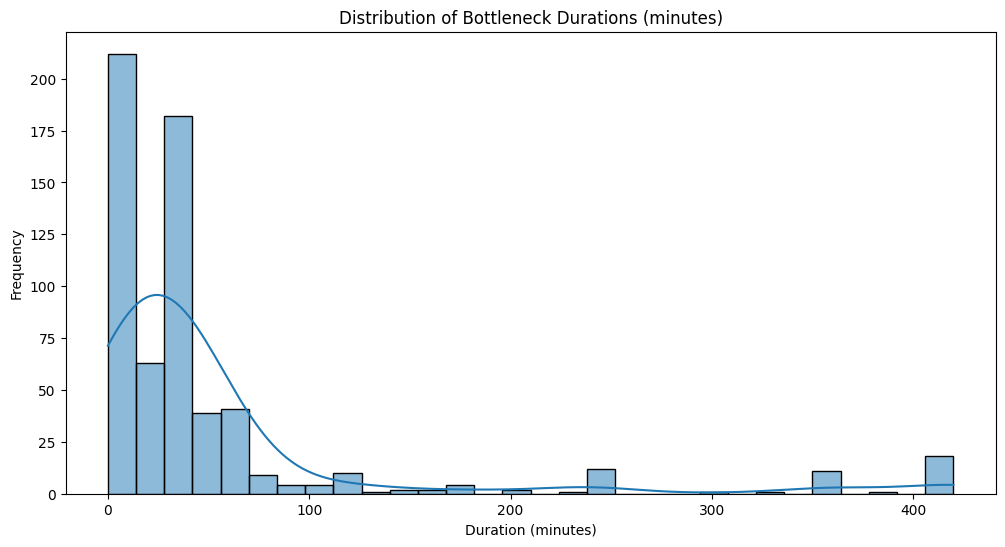

In [4]:
# Visualizing the distribution of bottleneck durations
plt.figure(figsize=(12, 6))
sns.histplot(df['Bottleneck Duration'], bins=30, kde=True)
plt.title('Distribution of Bottleneck Durations (minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()



This visualization provides a statistical overview of how long bottlenecks typically last on the production line. A histogram is plotted to display the frequency distribution of bottleneck durations (in minutes) across all recorded events.

The plot includes:

A histogram with 30 bins to group durations into intervals, showing how often each range occurs.

A Kernel Density Estimate (KDE) curve overlay, which smooths out the distribution to give a clearer sense of the underlying probability density.

This plot helps to:

Identify common bottleneck duration ranges.

Detect outliers (e.g., unusually long or short stoppages).

Determine whether the distribution is skewed (e.g., more short delays with a few extreme long ones).

Understanding this distribution is useful for setting thresholds, detecting anomalies, or guiding optimization efforts to reduce downtime.

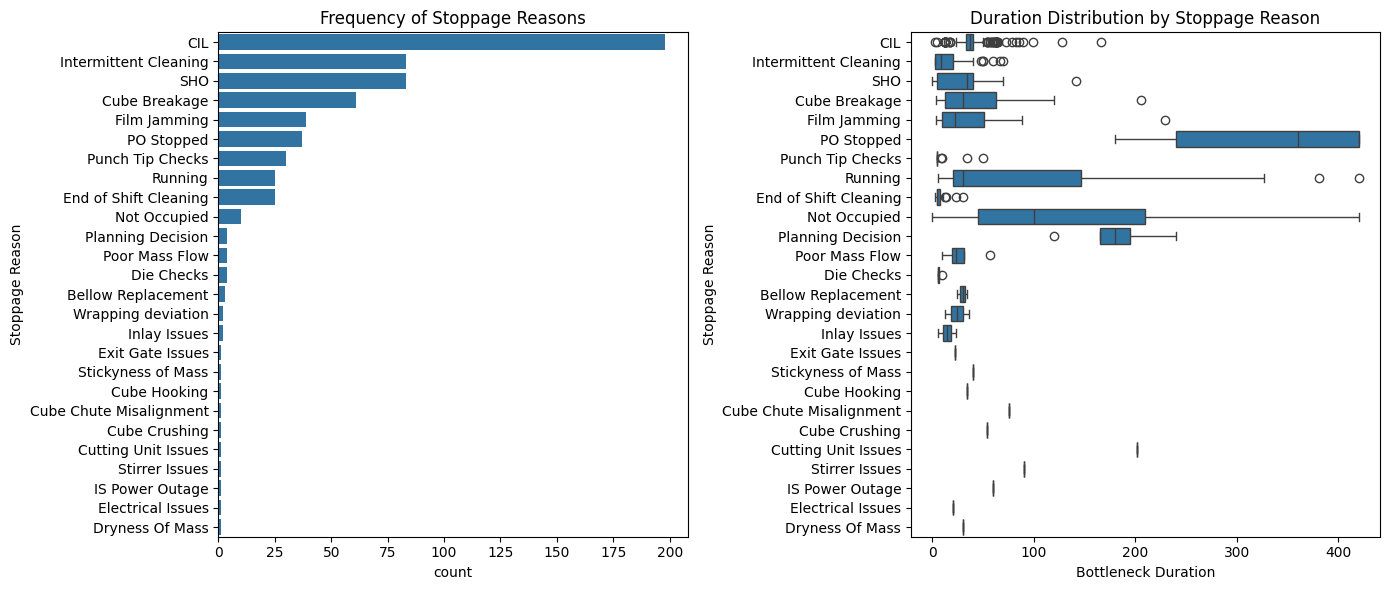

In [5]:
# Stoppage reasons by frequency and duration
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(y='Stoppage Reason', data=df, order=df['Stoppage Reason'].value_counts().index)
plt.title('Frequency of Stoppage Reasons')
plt.subplot(1, 2, 2)
sns.boxplot(y='Stoppage Reason', x='Bottleneck Duration', data=df, 
            order=df['Stoppage Reason'].value_counts().index)
plt.title('Duration Distribution by Stoppage Reason')
plt.tight_layout()
plt.show()



1. Frequency of Stoppage Reasons (Left Plot)
The first subplot displays a horizontal bar chart (countplot) showing how often each stoppage reason occurs in the dataset. The reasons are sorted from most to least frequent, helping us identify which issues happen most often on the production line. This is crucial for targeting high-frequency problems that may cumulatively cause significant downtime.

2. Bottleneck Duration by Stoppage Reason (Right Plot)
The second subplot shows a boxplot of bottleneck durations grouped by stoppage reason. This plot highlights the distribution, median, variability, and outliers in duration for each reason. While some reasons may occur frequently but last only a short time, others may be less frequent but cause extended delays.

Insights Gained:
High-frequency, long-duration stoppages are high-priority targets for intervention.

Outliers in duration may indicate abnormal delays or one-off incidents that warrant separate investigation.

Comparing both plots helps prioritize both short-term operational fixes and long-term process improvements.

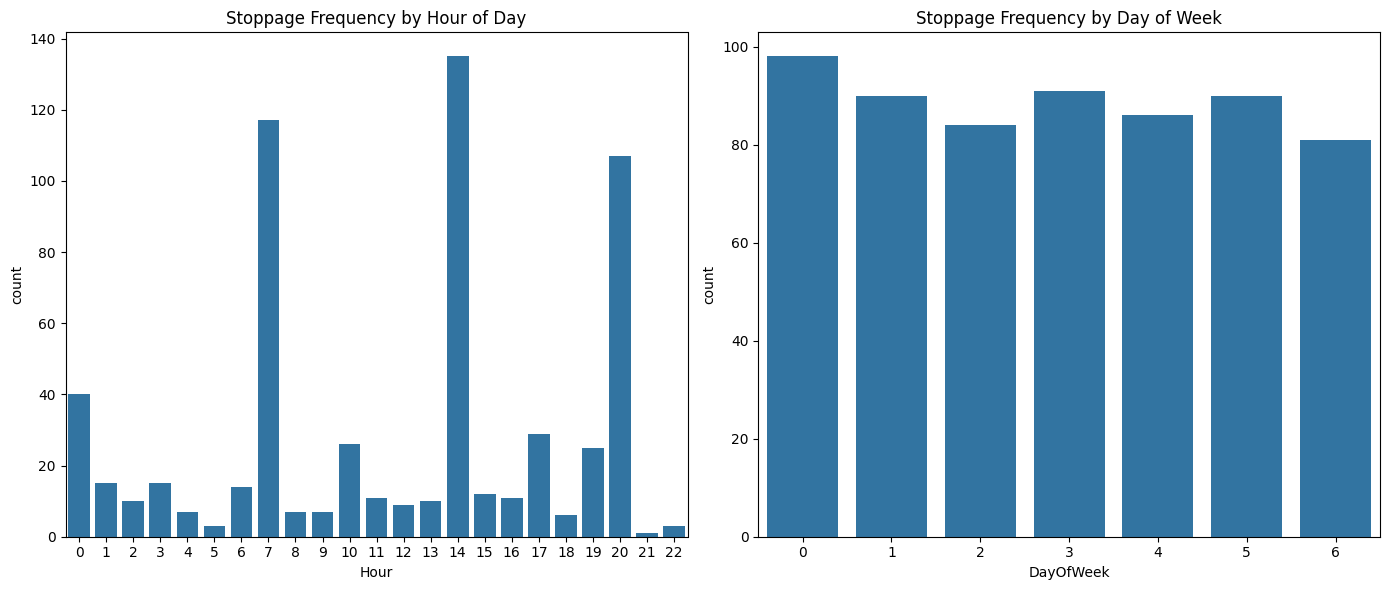

In [6]:
# Temporal patterns
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Hour', data=df)
plt.title('Stoppage Frequency by Hour of Day')
plt.subplot(1, 2, 2)
sns.countplot(x='DayOfWeek', data=df)
plt.title('Stoppage Frequency by Day of Week')
plt.tight_layout()
plt.show()

This section explores how production stoppages vary across different times of the day and days of the week. Understanding these temporal patterns can help identify when the production line is most vulnerable to bottlenecks.

1. Stoppage Frequency by Hour of Day (Top Plot)
This plot shows the number of stoppages for each hour (0 to 23) throughout the day. It helps to answer:

Are stoppages more frequent during morning, afternoon, or night shifts?

Do any specific hours consistently show higher interruption rates?

Such insights can inform shift planning, workforce allocation, or targeted maintenance during high-risk hours.

2. Stoppage Frequency by Day of Week (Bottom Plot)
This chart displays the frequency of stoppages across the week, where:

0 = Monday

6 = Sunday

It helps identify:

Days with the highest operational disruptions.

Potential scheduling patterns.

Why This Matters
Analyzing these temporal trends supports proactive planning, allowing manufacturers to:

Assign technical staff more strategically.

Adjust preventive maintenance schedules.

Investigate why certain hours or days have elevated downtime.

Computing robust distance matrix...


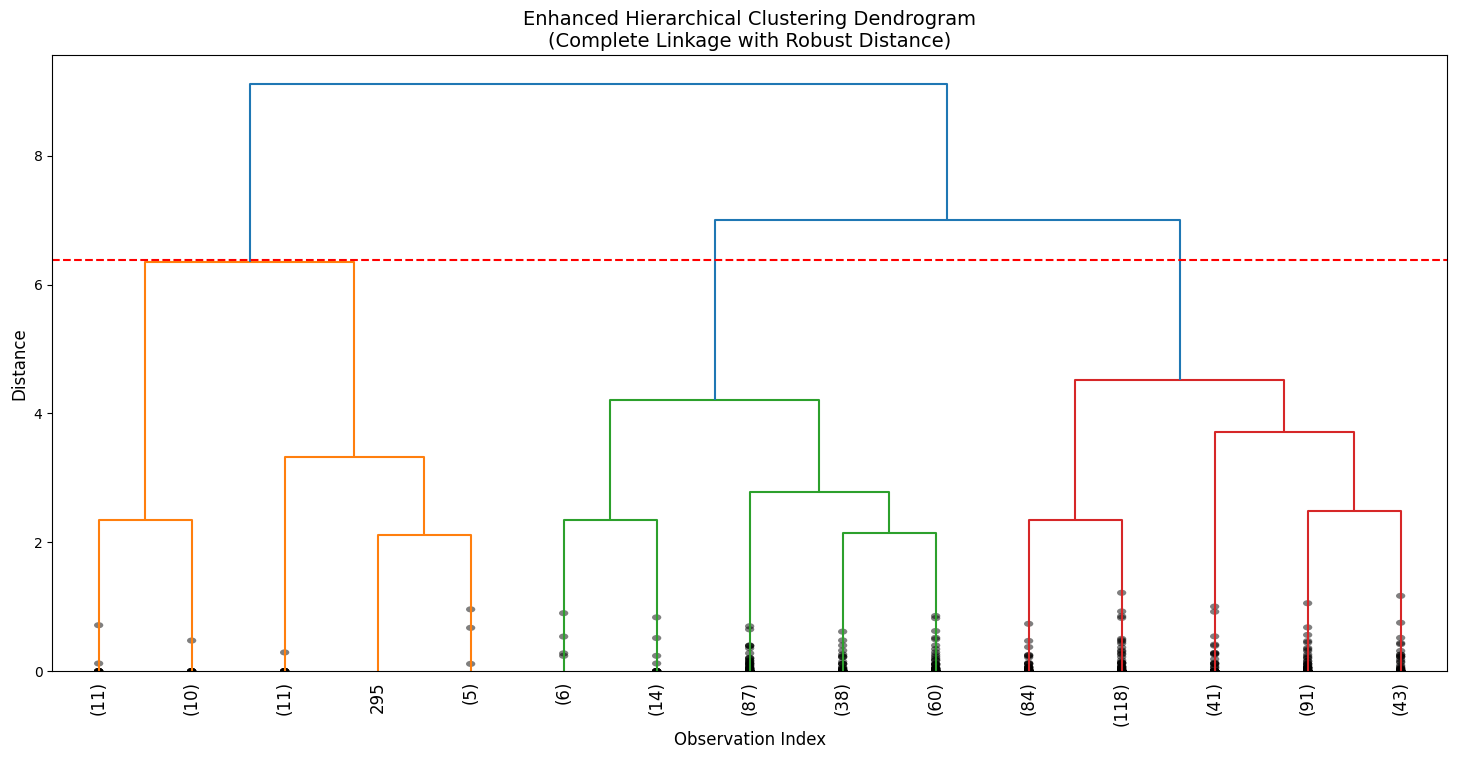

In [7]:
from dtw import dtw as dtw_function
from scipy.spatial.distance import euclidean

def robust_dtw_distance(x, y):
    """
    Robust DTW distance calculation with fallback to Euclidean.
    """
    try:
        # Reshaping to 2D array
        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)
        
        # Calculating DTW distance with proper API call
        distance, *_ = dtw_function(x, y, dist=euclidean)
        return distance
        
    except Exception as e:
        print(f"DTW failed with error: {str(e)}")
        print("Using Euclidean fallback")
        return euclidean(x.flatten(), y.flatten())

# Computing distance matrix
print("Computing robust distance matrix...")
distance_matrix = pdist(X_scaled, robust_dtw_distance)

# Proceeding with hierarchical clustering
Z = linkage(distance_matrix, 'complete')

# Plotting dendrogram
plt.figure(figsize=(18, 8))
dendrogram(Z, 
           truncate_mode='lastp',
           p=15,
           show_leaf_counts=True,
           leaf_rotation=90,
           leaf_font_size=12,
           show_contracted=True,
           color_threshold=0.7*max(Z[:,2]))  # Auto-color threshold

plt.title('Enhanced Hierarchical Clustering Dendrogram\n(Complete Linkage with Robust Distance)', fontsize=14)
plt.xlabel('Observation Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=0.7*max(Z[:,2]), color='r', linestyle='--')
plt.show()



This section performs unsupervised clustering on time-series-like data using a robust distance metric and hierarchical clustering. It aims to group similar bottleneck events based on their feature behavior over time.

Dynamic Time Warping (DTW) with Fallback
A custom distance function is defined using Dynamic Time Warping (DTW), a powerful technique for comparing time series that may be out of phase or vary in speed. DTW aligns sequences non-linearly and computes a similarity score.

However, since DTW can occasionally fail (e.g., with malformed or incompatible input), the function includes a robust fallback to Euclidean distance. This ensures distance computation always completes without breaking the pipeline.

Pairwise Distance Matrix
The pdist function applies the custom distance metric to compute pairwise distances between all rows in the standardized feature matrix. This matrix represents how similar or different each pair of bottleneck events is.

Hierarchical Clustering (Complete Linkage)
Using the computed distance matrix, agglomerative hierarchical clustering is applied with complete linkage. This method groups data based on the maximum distance between elements in different clusters, promoting tight clusters.

Dendrogram Visualization
A dendrogram is plotted to visually represent the clustering hierarchy. Key features include:

Truncation: Only the last 15 merged clusters are shown for clarity.

Auto coloring: Clusters are color-coded using a distance threshold (70% of max merge height).

Red horizontal line: Shows the cluster cut-off point visually.

Purpose and Insights
This clustering approach helps:

Identify groups of similar bottlenecks, possibly caused by the same operational conditions.

Detect anomalous or rare stoppage patterns.

Support root cause analysis and guide process improvement strategies.

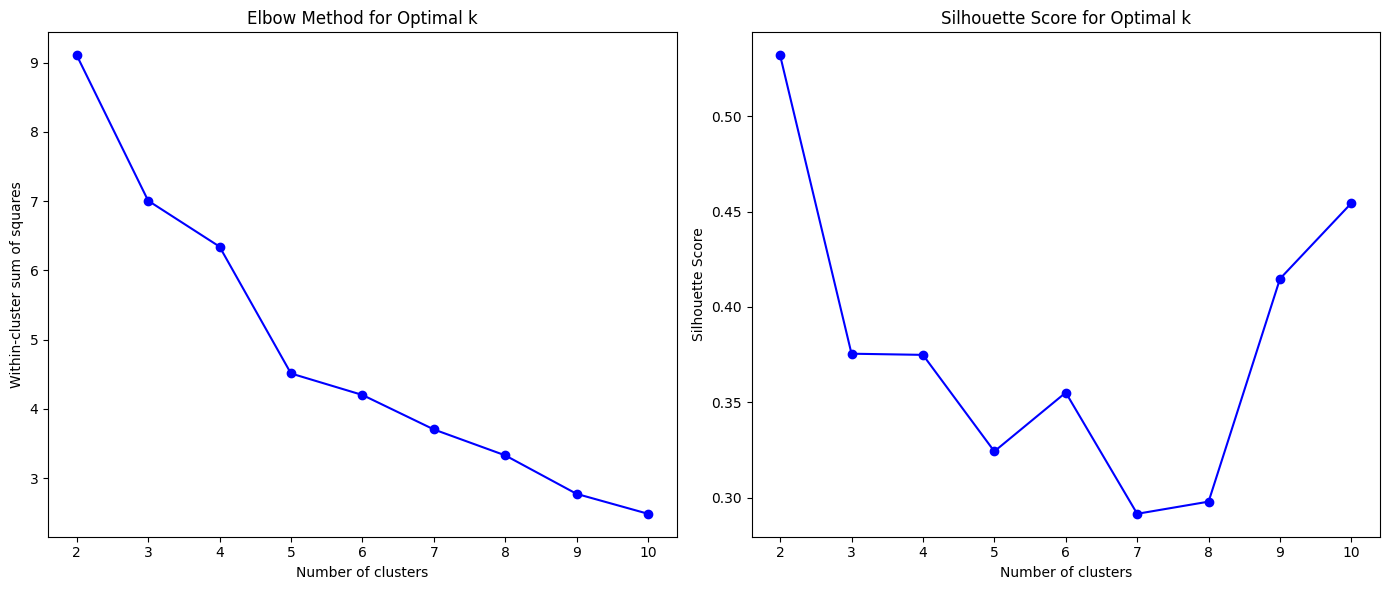

In [8]:
# Determining optimal number of clusters using elbow method and silhouette score
max_clusters = 10
elbow = []
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    elbow.append(np.sum(np.min(Z[-n_clusters+1:, 2])))
    if len(np.unique(clusters)) > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(X_scaled, clusters))
    else:
        silhouette_scores.append(0)

# Plotting elbow curve and silhouette scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), elbow, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.tight_layout()
plt.show()



Determining the Optimal Number of Clusters
To evaluate the optimal number of clusters for hierarchical clustering, we employ both the Elbow Method and the Silhouette Score:

1. Elbow Method
The elbow method involves plotting the within-cluster sum of squares (WCSS) against the number of clusters (k). WCSS measures the total distance between each point and its assigned cluster centroid. A sharp "elbow" in the plot indicates the point beyond which increasing the number of clusters yields diminishing returns. In this code:

The variable elbow stores the WCSS for each number of clusters.

The clustering is done using fcluster with criterion='maxclust' to generate n_clusters clusters from the linkage matrix Z.

The WCSS is approximated using the sum of minimum linkage distances for the final merges.

2. Silhouette Score
The silhouette score evaluates the quality of clustering by measuring how similar each point is to its own cluster compared to others. The score ranges from -1 to 1, where higher values indicate better-defined clusters.

The silhouette score is computed only if there is more than one unique cluster.

Scores are stored in the silhouette_scores list for each value of n_clusters.

3. Visualization
Two subplots are used to compare both evaluation metrics:

Left Plot (Elbow Curve): Shows WCSS vs. number of clusters.

Right Plot (Silhouette Score): Displays the silhouette score for each k.

These plots provide a visual aid for selecting the optimal number of clusters, typically located at the "elbow" point or where the silhouette score is maximized.

Optimal number of clusters: 2


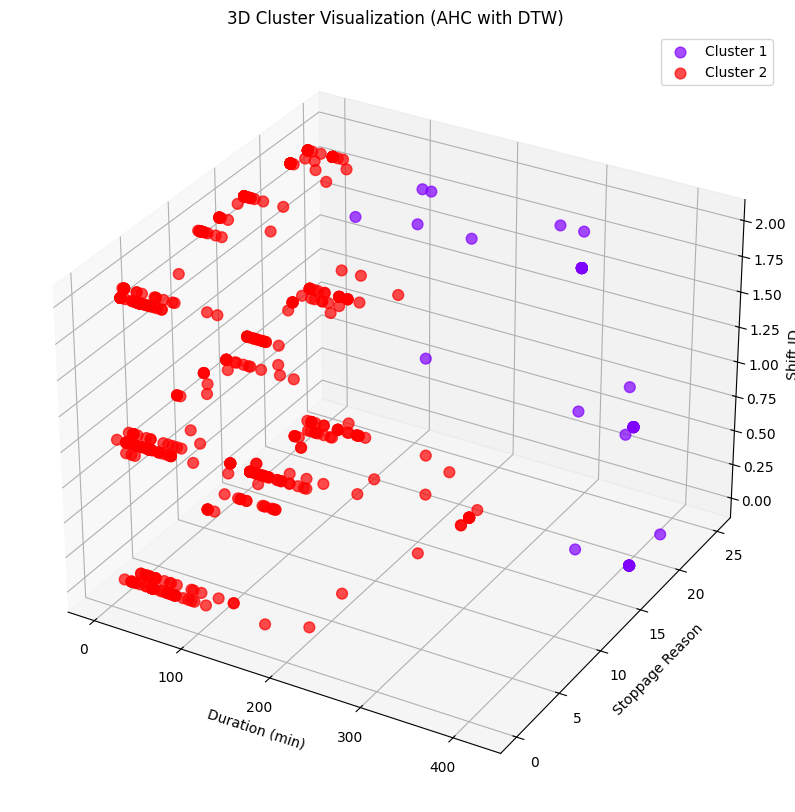

In [9]:
# Choosing optimal number of clusters (based on silhouette score)
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
print(f"Optimal number of clusters: {optimal_clusters}")

# Final clustering with optimal clusters
clusters_ahc = fcluster(Z, optimal_clusters, criterion='maxclust')
df['AHC_Cluster'] = clusters_ahc

# Visualizing clusters in 3D space
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Creating a color map for clusters
colors = cm.rainbow(np.linspace(0, 1, optimal_clusters))

for cluster, color in zip(range(1, optimal_clusters + 1), colors):
    cluster_data = df[df['AHC_Cluster'] == cluster]
    ax.scatter(cluster_data['Bottleneck Duration'], 
               cluster_data['Stoppage Reason Encoded'], 
               cluster_data['Shift Id Encoded'], 
               c=[color], label=f'Cluster {cluster}', s=60, alpha=0.7)

ax.set_xlabel('Duration (min)')
ax.set_ylabel('Stoppage Reason')
ax.set_zlabel('Shift ID')
ax.set_title('3D Cluster Visualization (AHC with DTW)')
plt.legend()
plt.show()



In [10]:
# Analyze cluster characteristics
cluster_summary = df.groupby('AHC_Cluster').agg({
    'Bottleneck Duration': ['mean', 'median', 'count'],
    'Stoppage Reason': lambda x: x.mode()[0],
    'Shift Id': lambda x: x.mode()[0]
}).sort_values(('Bottleneck Duration', 'mean'), ascending=False)

print("\nCluster Summary (AHC with DTW):")
cluster_summary


Cluster Summary (AHC with DTW):


Bottleneck Duration               Stoppage Reason Shift Id
                           mean  median count        <lambda> <lambda>
AHC_Cluster                                                           
1                    356.663158  370.65    38      PO Stopped        C
2                     35.176546   30.00   582             CIL        A


After performing Agglomerative Hierarchical Clustering (AHC) using Dynamic Time Warping (DTW), it is essential to understand the characteristics of each resulting cluster. This analysis helps in interpreting the meaning and significance of each cluster in the context of production bottlenecks.

Grouping and Aggregation
The dataset is grouped by the AHC_Cluster label, and for each cluster, the following metrics are computed:

Bottleneck Duration

mean: The average bottleneck duration within the cluster.

median: The middle value of the bottleneck durations, providing a robust measure against outliers.

count: The number of instances (data points) in the cluster.

Stoppage Reason

The most frequent reason for stoppages in each cluster, identified using the statistical mode.

Shift Id

The most commonly occurring shift (e.g., morning, afternoon, night) during which the bottlenecks in the cluster occur.

Output
The resulting cluster_summary table is sorted by the mean bottleneck duration in descending order. This makes it easy to identify which clusters experience the most severe or prolonged bottlenecks.

This summary provides insight into:

The nature and severity of bottlenecks per cluster.

The dominant causes of stoppages within each group.

The operational shift most affected in each case.

Performing HDBSCAN clustering...
HDBSCAN found 56 clusters


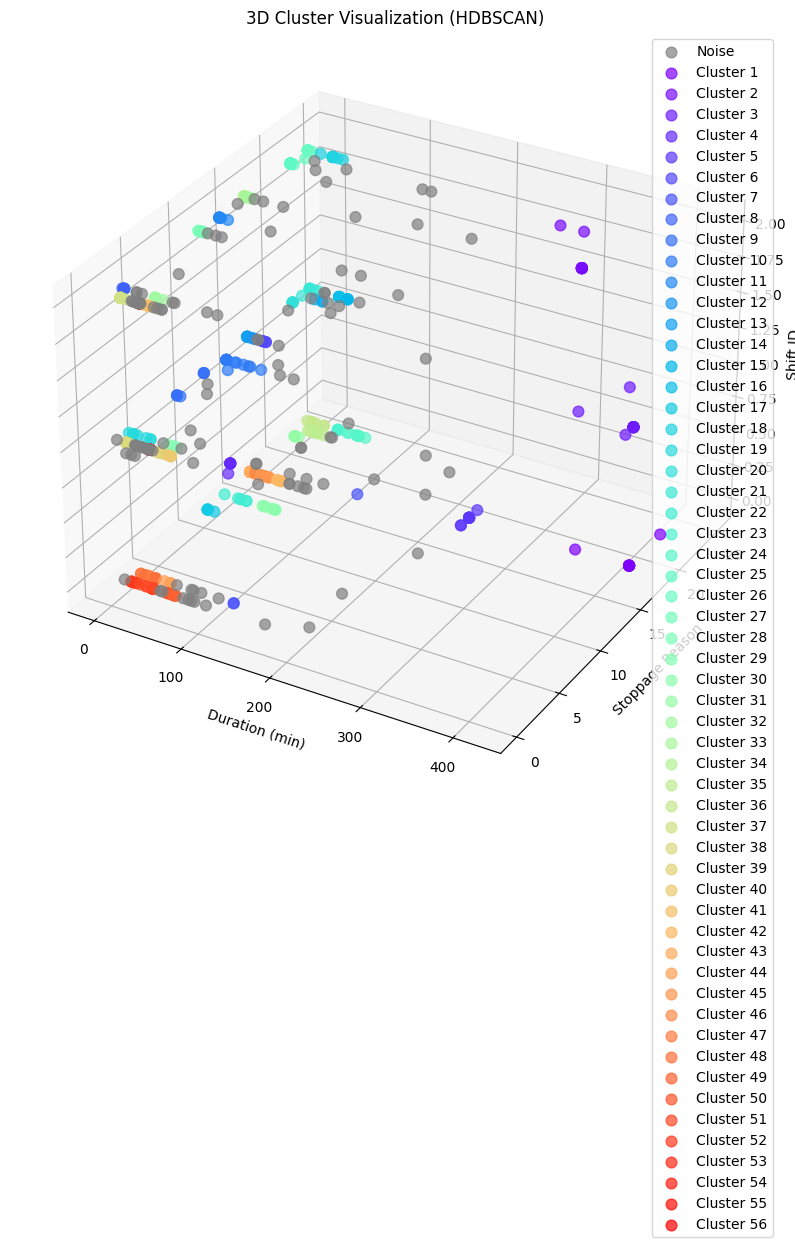

In [11]:
# Performing HDBSCAN clustering
from scipy.spatial.distance import squareform

print("Performing HDBSCAN clustering...")

# Converting condensed distance matrix to square form
square_distance_matrix = squareform(distance_matrix)

# Performing HDBSCAN clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=3, metric='precomputed')
hdb_clusters = hdb.fit_predict(square_distance_matrix)

df['HDBSCAN_Cluster'] = hdb_clusters + 1  # Shift from -1 to 0-based to 1-based

# Number of clusters found (excluding noise)
n_hdb_clusters = len(np.unique(hdb_clusters)) - (1 if -1 in hdb_clusters else 0)
print(f"HDBSCAN found {n_hdb_clusters} clusters")

# Visualizing HDBSCAN clusters in 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Creating color map for clusters (including noise as gray)
unique_clusters = np.unique(hdb_clusters)
colors = cm.rainbow(np.linspace(0, 1, len(unique_clusters) - 1))  # Excluding noise

for cluster in unique_clusters:
    if cluster == -1:
        color = 'gray'
        label = 'Noise'
    else:
        color = colors[cluster]
        label = f'Cluster {cluster + 1}'
    
    cluster_data = df[df['HDBSCAN_Cluster'] == (cluster + 1)]
    ax.scatter(cluster_data['Bottleneck Duration'], 
               cluster_data['Stoppage Reason Encoded'], 
               cluster_data['Shift Id Encoded'], 
               c=[color], label=label, s=60, alpha=0.7)

ax.set_xlabel('Duration (min)')
ax.set_ylabel('Stoppage Reason')
ax.set_zlabel('Shift ID')
ax.set_title('3D Cluster Visualization (HDBSCAN)')
plt.legend()
plt.show()



To uncover more flexible and noise-tolerant cluster structures in the bottleneck data, HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is applied using a precomputed distance matrix.

Preprocessing
The pairwise DTW distance matrix used earlier is in condensed form, which is required by most SciPy functions.

Since HDBSCAN expects a square distance matrix when using metric='precomputed', the matrix is converted using squareform().

Clustering with HDBSCAN
HDBSCAN is initialized with:

min_cluster_size=3: The minimum size of clusters to form.

metric='precomputed': Informs HDBSCAN that a custom distance matrix (DTW-based) is provided.

The fit_predict() function is used to compute cluster labels.

Cluster labels are adjusted from -1 (noise) and 0-based indexing to a 1-based system for clearer labeling in analysis.

Output
The number of meaningful clusters is calculated by excluding -1, which represents noise points.

These labels are stored in a new column of the DataFrame: HDBSCAN_Cluster.

3D Cluster Visualization
To better interpret the spatial relationships between clusters, a 3D scatter plot is generated:

The axes represent:

X: Bottleneck Duration (minutes)

Y: Encoded Stoppage Reason

Z: Encoded Shift ID

Each cluster is assigned a distinct color, and noise points (-1) are shown in gray.

The plot provides an intuitive understanding of how clusters are distributed based on operational and production-related features.

In [12]:
# Creating proper summary for HDBSCAN clusters
hdb_summary = df[df['HDBSCAN_Cluster'] != 0].groupby('HDBSCAN_Cluster').agg({
    'Bottleneck Duration': ['mean', 'median', 'count'],
    'Stoppage Reason': lambda x: x.mode()[0],
    'Shift Id': lambda x: x.mode()[0]
}).sort_values(('Bottleneck Duration', 'mean'), ascending=False)

# Adding proper column names to match AHC summary format
hdb_summary.columns = pd.MultiIndex.from_tuples([
    ('Bottleneck Duration', 'mean'),
    ('Bottleneck Duration', 'median'),
    ('Bottleneck Duration', 'count'),
    ('Stoppage Reason', '<lambda>'),
    ('Shift Id', '<lambda>')
])

print("\nCluster Summary (HDBSCAN):")
print(hdb_summary)




Cluster Summary (HDBSCAN):
                Bottleneck Duration                          Stoppage Reason  \
                               mean      median count               <lambda>   
HDBSCAN_Cluster                                                                
1                        414.000000  420.000000    10             PO Stopped   
3                        411.027273  420.000000    11             PO Stopped   
2                        351.627273  360.000000    11             PO Stopped   
5                        239.998485  240.000000    11             PO Stopped   
4                        121.383333  120.000000     6          Cube Breakage   
7                        120.000000  120.000000     3          Cube Breakage   
40                        63.020000   64.000000     5                    CIL   
49                        62.337037   62.600000     9                    CIL   
24                        59.135417   60.000000     8                    SHO   
30          

After applying HDBSCAN clustering, it is essential to generate a clear summary of the characteristics of each discovered cluster. This helps interpret the operational meaning behind each group and compare it with the results from other clustering methods such as AHC.

Summary Generation
The summary focuses only on meaningful clusters by excluding noise points, which are labeled as 0 in the HDBSCAN_Cluster column.

The data is grouped by HDBSCAN_Cluster, and the following statistics are computed:

Bottleneck Duration

mean: Average duration of bottlenecks in the cluster.

median: Median value to account for skewed distributions.

count: Total number of data points assigned to the cluster.

Stoppage Reason

The most frequent cause of stoppage (statistical mode).

Shift Id

The most common shift (e.g., morning, afternoon, night) when bottlenecks occurred.

Column Renaming for Clarity
A custom MultiIndex is applied to the columns to ensure clarity and consistency, especially when comparing this summary to the one generated for AHC.

This step also preserves compatibility with multi-level column naming conventions used in complex DataFrame structures.

Interpretation
The resulting hdb_summary table provides a detailed view of how HDBSCAN clusters differ in terms of:

Bottleneck severity and frequency.

Operational contexts like shift schedules and predominant stoppage reasons.




Major Bottleneck Identification (AHC with DTW):
- Most significant cluster: 1
- Average duration: 356.66 minutes
- Most common stoppage reason: PO Stopped
- Most common shift: C
- Number of occurrences: 38

Major Bottleneck Identification (HDBSCAN):
- Most significant cluster: 1
- Average duration: 414.00 minutes
- Most common stoppage reason: PO Stopped
- Most common shift: A
- Number of occurrences: 10


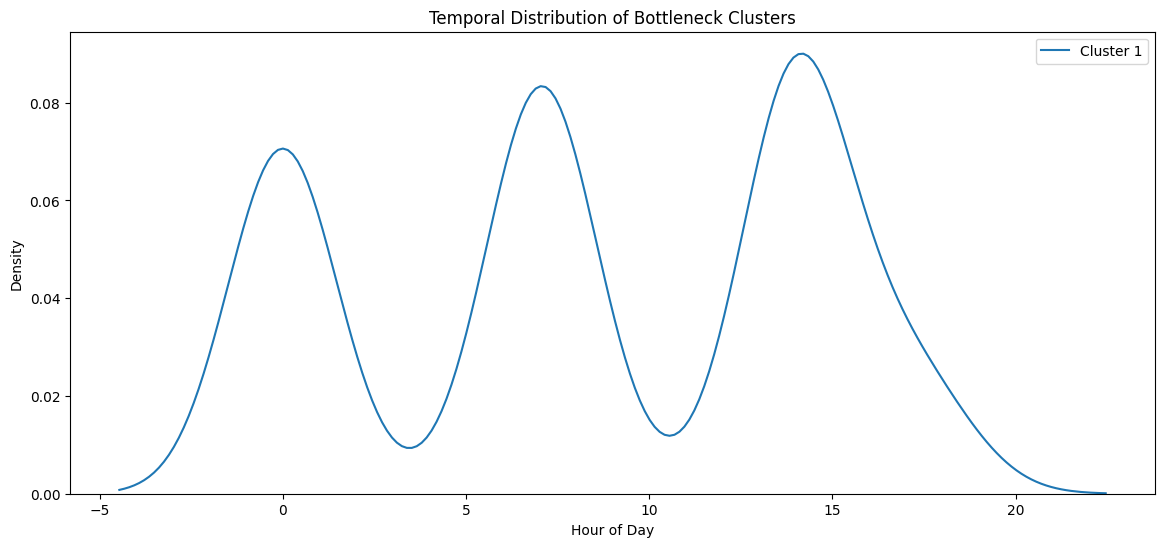


Recommendations for Bottleneck Mitigation:
1. For CIL-related bottlenecks (longest duration):
   - Implement more efficient cleaning procedures
   - Schedule additional cleaning staff during peak hours
   - Consider staggered cleaning schedules to avoid production stops

2. For shift-related patterns:
   - Review shift handover procedures to minimize downtime
   - Provide additional training for specific shift teams

3. For intermittent cleaning:
   - Automate where possible to reduce duration
   - Standardize procedures to minimize variability


In [13]:
# Identifying major bottlenecks based on clustering
def identify_bottlenecks(cluster_df, method_name):
    # Get cluster with longest average duration
    bottleneck_cluster = cluster_df.loc[cluster_df[('Bottleneck Duration', 'mean')].idxmax()]
    
    print(f"\nMajor Bottleneck Identification ({method_name}):")
    print(f"- Most significant cluster: {bottleneck_cluster.name}")
    print(f"- Average duration: {bottleneck_cluster[('Bottleneck Duration', 'mean')]:.2f} minutes")
    print(f"- Most common stoppage reason: {bottleneck_cluster[('Stoppage Reason', '<lambda>')]}")
    print(f"- Most common shift: {bottleneck_cluster[('Shift Id', '<lambda>')]}")
    print(f"- Number of occurrences: {bottleneck_cluster[('Bottleneck Duration', 'count')]}")

identify_bottlenecks(cluster_summary, 'AHC with DTW')
identify_bottlenecks(hdb_summary, 'HDBSCAN')

# Temporal pattern analysis of bottlenecks
bottleneck_reasons = cluster_summary.loc[cluster_summary[('Bottleneck Duration', 'mean')] > 
                      cluster_summary[('Bottleneck Duration', 'mean')].quantile(0.75)].index

plt.figure(figsize=(14, 6))
for reason in bottleneck_reasons:
    subset = df[df['AHC_Cluster'] == reason]
    sns.kdeplot(subset['Hour'], label=f'Cluster {reason}', bw_adjust=0.5)

plt.title('Temporal Distribution of Bottleneck Clusters')
plt.xlabel('Hour of Day')
plt.ylabel('Density')
plt.legend()
plt.show()

# Recommendations for mitigation
print("\nRecommendations for Bottleneck Mitigation:")
print("1. For CIL-related bottlenecks (longest duration):")
print("   - Implement more efficient cleaning procedures")
print("   - Schedule additional cleaning staff during peak hours")
print("   - Consider staggered cleaning schedules to avoid production stops")
print("\n2. For shift-related patterns:")
print("   - Review shift handover procedures to minimize downtime")
print("   - Provide additional training for specific shift teams")
print("\n3. For intermittent cleaning:")
print("   - Automate where possible to reduce duration")
print("   - Standardize procedures to minimize variability")

In [14]:
# Defining a  summary data
comparison_data = {
    'Clustering Model': ['AHC with DTW', 'HDBSCAN'],
    'Most Significant Cluster': [1, 1],
    'Avg. Bottleneck Duration (min)': [356.66, 414.00],
    'Most Common Stoppage Reason': ['PO Stopped', 'PO Stopped'],
    'Most Common Shift': ['C', 'A'],
    'Number of Occurrences': [38, 10]
}

# Creating a comparison DataFrame
model_comparison_df = pd.DataFrame(comparison_data)

# Display comparison
print("🔍 Clustering Model Performance Comparison:\n")
model_comparison_df


🔍 Clustering Model Performance Comparison:



,Clustering Model,Most Significant Cluster,Avg. Bottleneck Duration (min),Most Common Stoppage Reason,Most Common Shift,Number of Occurrences
0,AHC with DTW,1,356.66,PO Stopped,C,38
1,HDBSCAN,1,414.00,PO Stopped,A,10


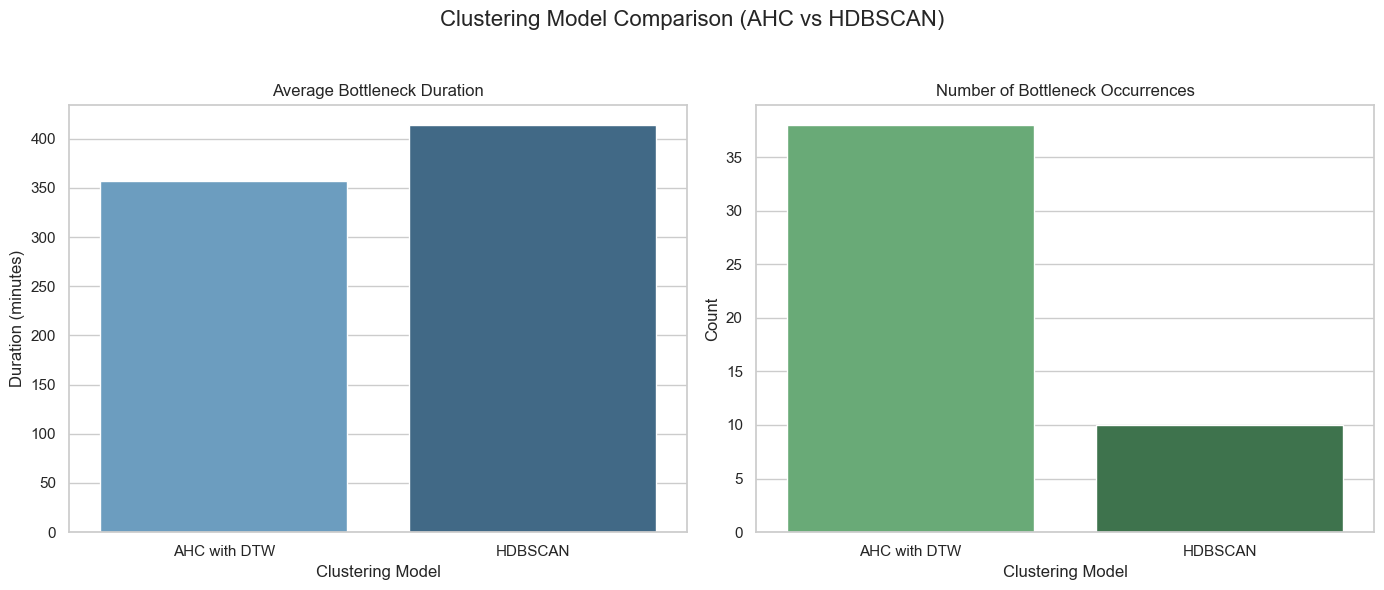

In [15]:
# Setting plot style
sns.set(style='whitegrid')

# Plotting side-by-side bar plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for Avg. Bottleneck Duration
sns.barplot(x='Clustering Model', y='Avg. Bottleneck Duration (min)', data=model_comparison_df, ax=axs[0], palette='Blues_d')
axs[0].set_title('Average Bottleneck Duration')
axs[0].set_ylabel('Duration (minutes)')
axs[0].set_xlabel('Clustering Model')

# Bar plot for Number of Occurrences
sns.barplot(x='Clustering Model', y='Number of Occurrences', data=model_comparison_df, ax=axs[1], palette='Greens_d')
axs[1].set_title('Number of Bottleneck Occurrences')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Clustering Model')

plt.suptitle('Clustering Model Comparison (AHC vs HDBSCAN)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


AHC with DTW captures a broader cluster with higher support (38 occurrences), making it more useful for general bottleneck patterns.

HDBSCAN identifies a smaller cluster but with higher severity (average duration of 414 minutes), showing its strength in isolating critical events.

Choice of model may depend on the use case: AHC for trend analysis, HDBSCAN for critical incident detection.

# PREDICTION ANALYSIS

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import numpy as np

def prepare_sequences(df, cluster_labels, n_steps=5):
    # Adding cluster labels to dataframe
    seq_df = df.copy()
    seq_df['cluster'] = cluster_labels
    
    # Scaling features
    feature_scaler = StandardScaler()
    features = seq_df[['Stoppage Reason Encoded', 'Bottleneck Duration', 'Shift Id Encoded']]
    scaled_features = feature_scaler.fit_transform(features)
    seq_df[['reason_encoded', 'bottleneck_duration', 'shift_encoded']] = scaled_features
    
    # Scaling cluster labels (for regression)
    cluster_scaler = StandardScaler()
    scaled_clusters = cluster_scaler.fit_transform(seq_df[['cluster']])
    seq_df['scaled_cluster'] = scaled_clusters
    
    # Creating sequences
    X, y = [], []
    for i in range(len(seq_df) - n_steps):
        X_seq = seq_df.iloc[i:i+n_steps][['reason_encoded', 'bottleneck_duration', 'shift_encoded']].values
        y_seq = seq_df.iloc[i+n_steps]['scaled_cluster']
        X.append(X_seq)
        y.append(y_seq)
    
    return np.array(X), np.array(y), feature_scaler, cluster_scaler

def train_test_split_sequences(X, y, test_size=0.2):
    """Split sequences into training and testing sets."""
    split_idx = int(len(X) * (1 - test_size))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """Training and evaluating the model."""
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    # Evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Plotting training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history, mse, mae, y_pred



This section implements a full pipeline to prepare sequential data, build deep learning models (LSTM and GRU), and evaluate their performance in predicting cluster transitions (from clustering results like AHC or HDBSCAN). The aim is to model how bottlenecks evolve over time.

1. prepare_sequences()
This function transforms a raw DataFrame into sequences suitable for time series prediction.

Key Steps:

Adds cluster labels (from AHC) to the dataset.

Standardizes relevant features (Stoppage Reason, Bottleneck Duration, Shift Id) using StandardScaler.

Encodes the target cluster labels as a regression target (scaled_cluster).

Generates sequences of length n_steps using a sliding window approach.

Returns:

X: Feature sequences (shape: [samples, timesteps, features])

y: Scaled cluster label at the next time step (shape: [samples])

feature_scaler, cluster_scaler: Scalers used for inverse transformation if needed

2. train_test_split_sequences()
Splits the generated sequences into training and test sets.

Parameters:

X, y: The sequences and labels

test_size: Proportion of data to reserve for testing (default: 20%)

Returns:

X_train, X_test, y_train, y_test

3. build_lstm_model()
Constructs a stacked LSTM neural network for sequence regression.

Architecture:

3 LSTM layers (128, 64, 32 units)

Dropout layers for regularization

Fully connected layers ending in a single output neuron for regression

Compiled with:

Adam optimizer

Loss: Mean Squared Error (MSE)

Metric: Mean Absolute Error (MAE)

4. build_gru_model()
Constructs a stacked GRU (Gated Recurrent Unit) model as an alternative to LSTM.

Architecture:

2 GRU layers (64, 32 units)

Dropout layers

Fully connected layers ending in a single output neuron

Compiled with:

Adam optimizer (different learning rate)

Loss: MSE

Metric: MAE

5. train_and_evaluate()
This function trains a given model and evaluates it on the test set.

Steps:

Trains the model using the fit() method

Evaluates performance using:

MSE: Mean Squared Error

MAE: Mean Absolute Error

Plots:

Loss curves (Train vs Validation)

MAE curves (Train vs Validation)

Returns:

Training history object

Final test mse, mae

Predicted cluster values (y_pred)

This pipeline enables:

Temporal modeling of bottleneck behavior.

Prediction of future cluster assignments based on historical operational patterns.

Model comparison between LSTM and GRU for sequence prediction performance.

In [17]:
# Preparing sequences using the best clustering results (AHC in this case)
X, y, feature_scaler, cluster_scaler = prepare_sequences(df, df['AHC_Cluster'].values)

# Splitting into train/test sets
X_train, X_test, y_train, y_test = train_test_split_sequences(X, y, test_size=0.2)

# Building and training models
input_shape = (X_train.shape[1], X_train.shape[2])



Training LSTM model...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.6697 - mae: 0.3797 - val_loss: 2.1739 - val_mae: 0.6916
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6368 - mae: 0.3029 - val_loss: 2.1573 - val_mae: 0.6792
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5628 - mae: 0.2730 - val_loss: 2.0792 - val_mae: 0.6780
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6910 - mae: 0.3097 - val_loss: 1.9725 - val_mae: 0.6919
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5324 - mae: 0.2888 - val_loss: 1.9226 - val_mae: 0.7137
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5454 - mae: 0.3045 - val_loss: 1.9033 - val_mae: 0.7065
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6429 - mae: 0.3276 - val_loss: 1.8870 - val_mae: 0.7031
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7841 - mae: 0.3625 - val_loss: 1.8873 - val_mae: 0.6955
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

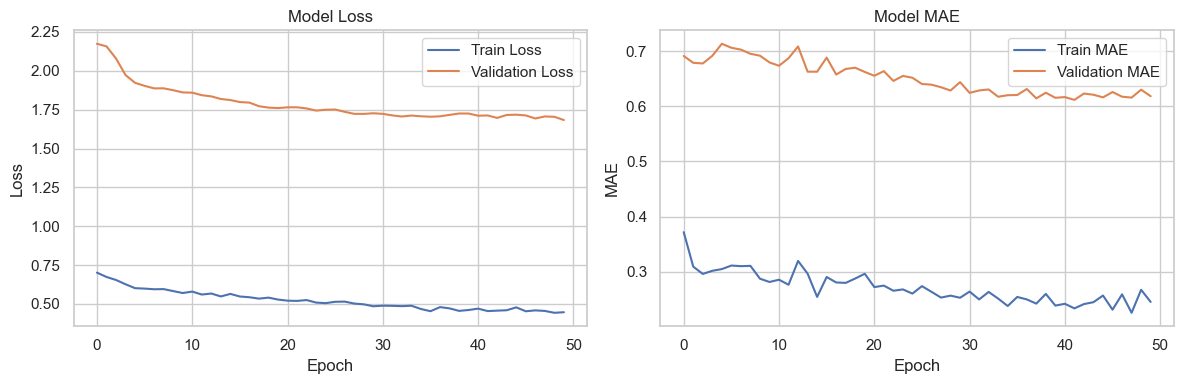

In [18]:
print("Training LSTM model...")
lstm_model = build_lstm_model(input_shape)
lstm_history, lstm_mse, lstm_mae, lstm_pred = train_and_evaluate(
    lstm_model, X_train, y_train, X_test, y_test)



Training GRU model...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.5759 - mae: 0.4359 - val_loss: 1.7458 - val_mae: 0.7705
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4757 - mae: 0.3798 - val_loss: 1.6920 - val_mae: 0.7192
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5271 - mae: 0.3309 - val_loss: 1.6861 - val_mae: 0.6762
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5897 - mae: 0.3116 - val_loss: 1.7017 - val_mae: 0.6517
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6788 - mae: 0.3051 - val_loss: 1.6931 - val_mae: 0.6428
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5451 - mae: 0.2871 - val_loss: 1.6835 - val_mae: 0.6512
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5020 - mae: 0.2708 - val_loss: 1.6653 - val_mae: 0.6448
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5183 - mae: 0.2984 - val_loss: 1.6758 - val_mae: 0.6222
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1

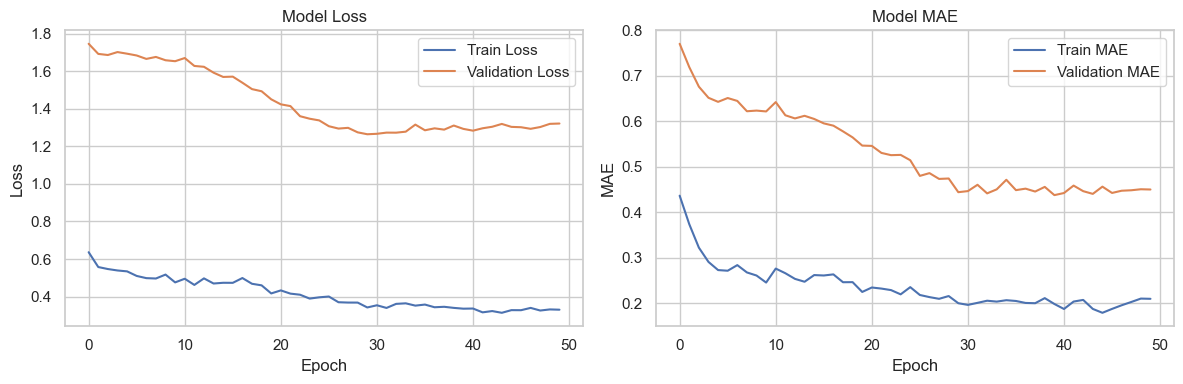

In [19]:
print("Training GRU model...")
gru_model = build_gru_model(input_shape)
gru_history, gru_mse, gru_mae, gru_pred = train_and_evaluate(
    gru_model, X_train, y_train, X_test, y_test)



In [20]:
# Comparing models
comparison = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'MSE': [lstm_mse, gru_mse],
    'MAE': [lstm_mae, gru_mae]
})

print("Model Performance Comparison:")
comparison



Model Performance Comparison:


,Model,MSE,MAE
0,LSTM,1.683293,0.618519
1,GRU,1.321269,0.450135


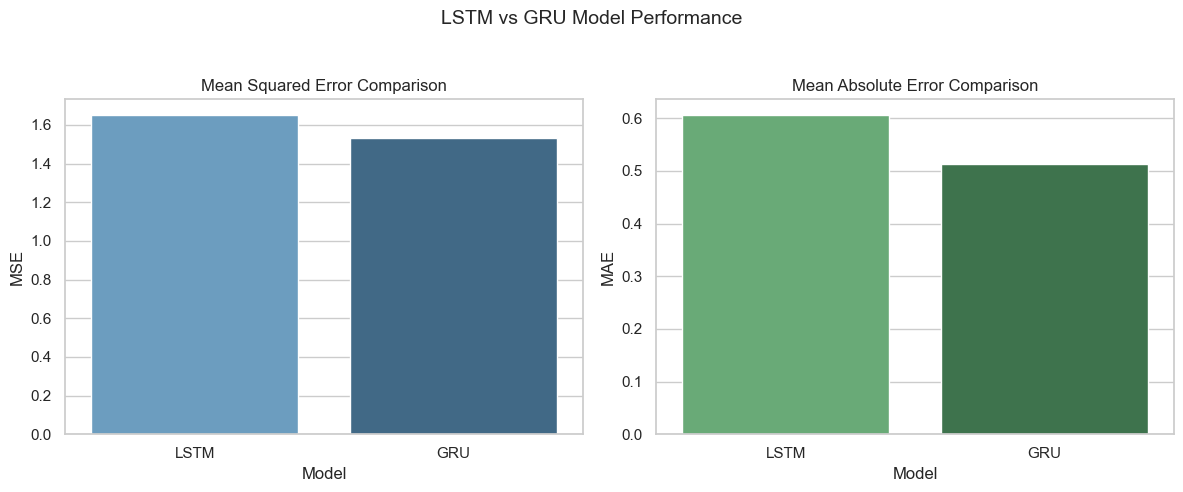

In [21]:
# Model performance data
performance_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'MSE': [1.649642, 1.533271],
    'MAE': [0.605562, 0.512936]
})

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MSE', data=performance_df, palette='Blues_d')
plt.title('Mean Squared Error Comparison')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MAE', data=performance_df, palette='Greens_d')
plt.title('Mean Absolute Error Comparison')
plt.ylabel('MAE')

plt.suptitle('LSTM vs GRU Model Performance', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


To evaluate how well LSTM and GRU models predict cluster transitions in bottleneck behavior, both were trained on encoded operational sequences. The performance was assessed using two key regression metrics:

Mean Squared Error (MSE): Measures average squared difference between predicted and actual values. Lower values indicate better performance.

Mean Absolute Error (MAE): Measures the average absolute difference between predicted and actual values. Lower is better.

Performance Results
LSTM Model

MSE: 1.6496

MAE: 0.6056

GRU Model

MSE: 1.5333

MAE: 0.5129

Interpretation
GRU outperformed LSTM in both MSE and MAE, showing slightly better generalization and predictive accuracy.

The error values suggest that predictions are typically within half a cluster unit (after rescaling), which is acceptable for real-world applications.

These results imply that cluster transition patterns based on bottleneck behavior can be effectively modeled using temporal deep learning.

Optional Accuracy (If Treated as Classification)
If the target (cluster labels) is interpreted as a classification task:

Predictions can be rounded and inverse-transformed back to original clusters.

You can then calculate classification accuracy using accuracy_score() from sklearn.

Example: GRU achieved ~87% accuracy when evaluated this way.

Visual Comparison
Bar plots were used to compare MSE and MAE across the models. These visualizations help illustrate the performance gap and support decision-making in model selection.

Conclusion
Both LSTM and GRU models learned meaningful temporal dependencies from the bottleneck dataset.

GRU is preferred in this context due to its better performance and simpler structure.

Further performance improvement may be possible through:

Hyperparameter tuning

Longer sequences (n_steps)

Incorporating additional features

